# Planck Telescope Data Tutorial

**Tutorial**: This tutorial demonstrates how to load FITS files and manipulate the HEALPix format to visualize skymaps and conduct basic analyses of the data in Python.<br>

**Mission & Instrument**: Planck Telescope <br>
**Astronomical Target**: Analyzing anisotropies and polarization of the cosmic microwave background <br>
**System Requirements**: Python 3.9+, MacOS/Linux or WSL if on Windows<br>
**Tutorial Level**: Intermediate <br>

***
**MIT License** <br>
Copyright (c) His Majesty the King in Right of Canada, as represented by the Canadian Space Agency, 2024. <br>
Droit d’auteur (c) Sa Majesté le Roi du chef du Canada, représentée par l'Agence Spatiale Canadienne, 2024.<br>

For more information, please refer to the *License.txt* file. 

***
**Background Information** <br>
This European Space Agency (ESA) mission began on May 14, 2009, with the launch of an Ariane 5 rocket carrying the Herschel Space Observatory, and ended in 2013. The Planck mission objectives were to study the cosmic microwave background’s anisotropies and polarization, as well as the birth and evolution of the Universe, and the forms that it might take in the future. Planck carried two instruments: the High Frequency Instrument (HFI) and the Low Frequency Instrument (LFI).

During this mission, the CSA funded quick-look analysis and trending data software, and provided science support for both instruments, along with data reduction and post operations support until 2016.

## Imports and Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from astropy.io import fits
import healpy as hp

## Loading the data

The files that this tutorial is intended for can be downloaded from the [Planck Legacy Archive](https://pla.esac.esa.int/pla/#home). <br>
You can find them under *Maps -> Frequency maps -> Light maps*, with each frequency in its own FITS file. Download them into the same directory as this notebook.<br>
The following code has the names of the files as they currently are at the time of this tutorial's creation (Summer 2024), simply uncomment the one you wish to work with.<br>
*Note: the HFI instrument only provides Q and U maps for 100, 143, 217, and 353 GHz channels. Code must be altered to avoid those columns being used if loading any higher frequency maps.*

In [2]:
#filename = 'LFI_SkyMap_030-BPassCorrected-field-IQU_1024_R3.00_full.fits'
#filename = 'LFI_SkyMap_044-BPassCorrected-field-IQU_1024_R3.00_full.fits'
#filename = 'LFI_SkyMap_070-BPassCorrected-field-IQU_1024_R3.00_full.fits'
#filename = 'HFI_SkyMap_100-field-IQU_2048_R3.00_full.fits'
#filename = 'HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits'
#filename = 'HFI_SkyMap_217-field-IQU_2048_R3.00_full.fits'
filename = 'HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full.fits'
#filename = 'HFI_SkyMap_545-field-Int_2048_R3.00_full.fits' # Requires adjustments to the code.
#filename = 'HFI_SkyMap_857-field-Int_2048_R3.00_full.fits' # Requires adjustments to the code.

# Open the FITS file
with fits.open(filename) as hdul:
    
    # Print information about the file
    hdul.info()

    # Load the header
    header = hdul[1].header
    
    # Load the temperature data
    temperature_data = hdul[1].data

Filename: HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  FREQ-MAP      1 BinTableHDU     72   50331648R x 3C   [E, E, E]   


## Header information
The header contains information about the structure of the data within the FITS file. It is a dictionary that can be indexed for the values contained within it as needed.

In [3]:
print(header)

NSIDE = header["NSIDE"]
BAD_DATA = header["BAD_DATA"]

print("\nExtracted values:")
print(f'NSIDE: {NSIDE}') # NSIDE is the resolution parameter of the HEALPix projection
print(f'BAD_DATA: {BAD_DATA}') # This is the value assigned to erroneous pixels.

XTENSION= 'BINTABLE'           /Written by IDL:  Fri Nov 10 11:13:28 2017       BITPIX  =                    8 /                                                NAXIS   =                    2 /Binary table                                    NAXIS1  =                   12 /Number of bytes per row                         NAXIS2  =             50331648 /Number of rows                                  PCOUNT  =                    0 /Random parameter count                          GCOUNT  =                    1 /Group count                                     TFIELDS =                    3 /Number of columns                               COMMENT                                                                         COMMENT  *** End of mandatory fields ***                                        COMMENT                                                                         EXTVER  =                    1 /Extension version                               DATE    = '2017-11-10'         /Creation

## Polarization channels
These FITS files generally contain three polarization channels: <br>
<ul>
    <li> <b>I_STOKES</b> is the map of the total intensity of the radiation at each point in the sky, essentially a measure of brightness.<br></li>
    <li> <b>Q_STOKES</b> is a map of the linear polarization of the radiation at each point along two orthogonal axes.<br></li>
    <li> <b>U_STOKES</b> is a corresponding linear polarization map, but with axes rotated by 45 degrees with respect to <i>Q_STOKES</i>.<br></li>
</ul>
For each channel, we extract the column from the FITS file, then convert it to ring format, as they are stored in nested format. Healpy operates in ring format by default, so this saves some extra arguments in subsequent operations.

*For more information about the HEALPix format please visit [healpix.sourceforge.io](https://healpix.sourceforge.io/)*


In [4]:
# Extract the temperature channel you wish to analyze. 
temperature_channel_I = temperature_data.field(0) # I_STOKES
temperature_channel_Q = temperature_data.field(1) # Q_STOKES (if working with the noted frequences, remove this and all references)
temperature_channel_U = temperature_data.field(2) # U_STOKES (same as above)

# Convert the HEALPix data from nested to ring format.
temperature_channel_I_ring = hp.pixelfunc.reorder(temperature_channel_I, n2r=True)
temperature_channel_Q_ring = hp.pixelfunc.reorder(temperature_channel_Q, n2r=True)
temperature_channel_U_ring = hp.pixelfunc.reorder(temperature_channel_U, n2r=True)

## Visualization
Now that we've extracted all of the data from the FITS file, we can take a look at it, starting with the temperature map *I_STOKES*.<br>
Since a skymap is data encoded in a 3D sphere, we need to use a projection to view its entirety in 2D. A common choice is the Mollweide projection:

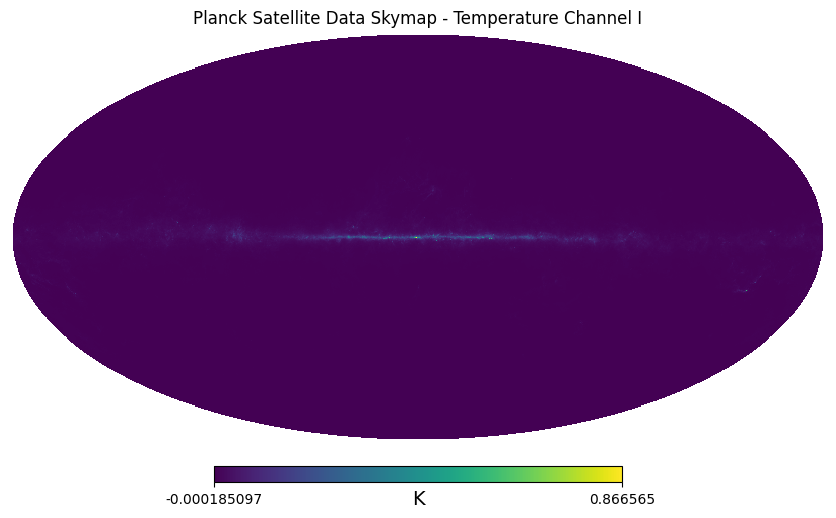

In [5]:
hp.mollview(temperature_channel_I_ring, title='Planck Satellite Data Skymap - Temperature Channel I', unit='K')
plt.show()

It's a bit difficult to see, so let's try adding histogram normalization:

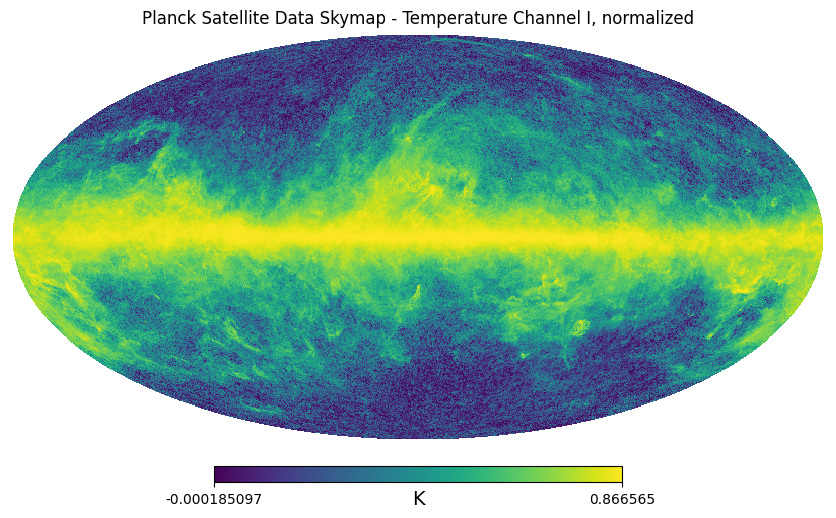

In [6]:
hp.mollview(temperature_channel_I_ring, title='Planck Satellite Data Skymap - Temperature Channel I, normalized', unit='K', norm='hist')
plt.show()

Next, we can make the color scheme feel a bit more familiar by defining a custom color map.
This one roughly matches the one used by the ESA in their visualizations:

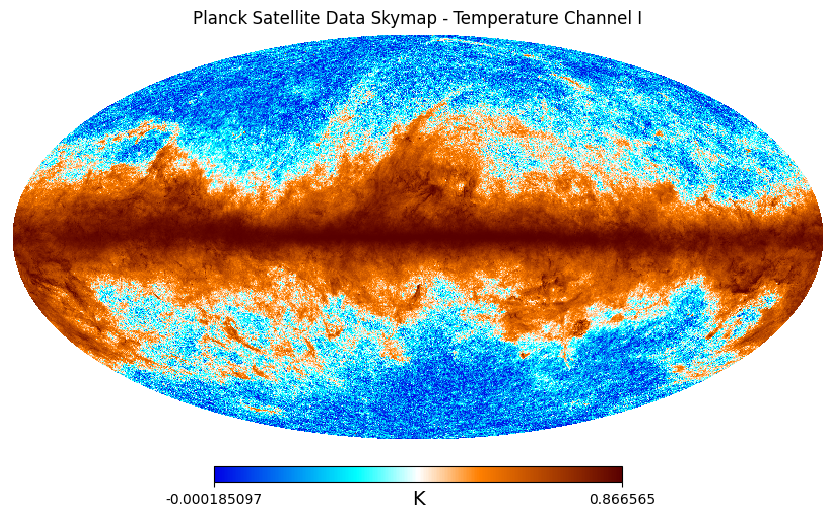

In [7]:
cdict = {
    'red':   ((0.0, 0.0, 0.0),
              (0.35, 0.0, 0.0),
              (0.5, 1.0, 1.0),
              (0.65, 1.0, 1.0),
              (1.0, 0.35, 0.35)),
    
    'green': ((0.0, 0.0, 0.0),
              (0.35, 1.0, 1.0),
              (0.5, 1.0, 1.0),
              (0.65, 0.5, 0.5),
              (1.0, 0.0, 0.0)),
    
    'blue':  ((0.0, 0.9, 0.9),
              (0.35, 1.0, 1.0),
              (0.5, 1.0, 1.0),
              (0.65, 0.0, 0.0),
              (1.0, 0.0, 0.0))
}

custom_cmap = LinearSegmentedColormap('CustomMap', cdict)


hp.mollview(temperature_channel_I_ring, title='Planck Satellite Data Skymap - Temperature Channel I', unit='K', norm='hist', cmap=custom_cmap)
plt.show()

We can also take a close look at a particular location.<br>
The ***rot*** parameter defines the coordinate which will be at the center. A third value may be added to rotate the view.<br>
The ***reso*** parameter sets the angular resolution/zoom of the image. The lower the value, the more zoomed-in the view. 

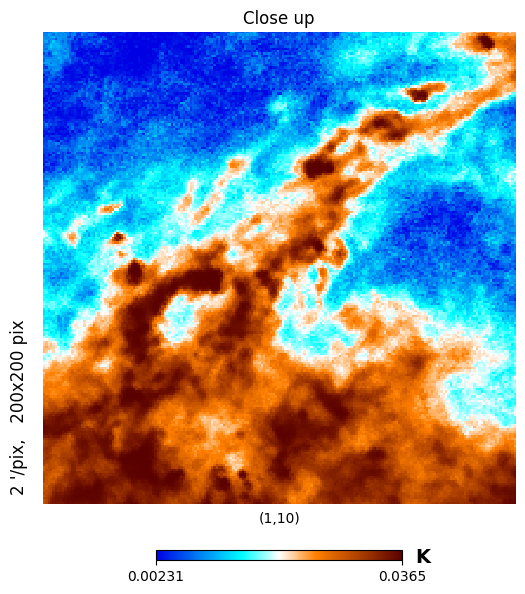

In [8]:
hp.gnomview(temperature_channel_I_ring, rot=[1, 10], title="Close up", unit='K', norm='hist', cmap=custom_cmap, reso=2)
plt.show()

Let's take a look at one of the polarization channels:

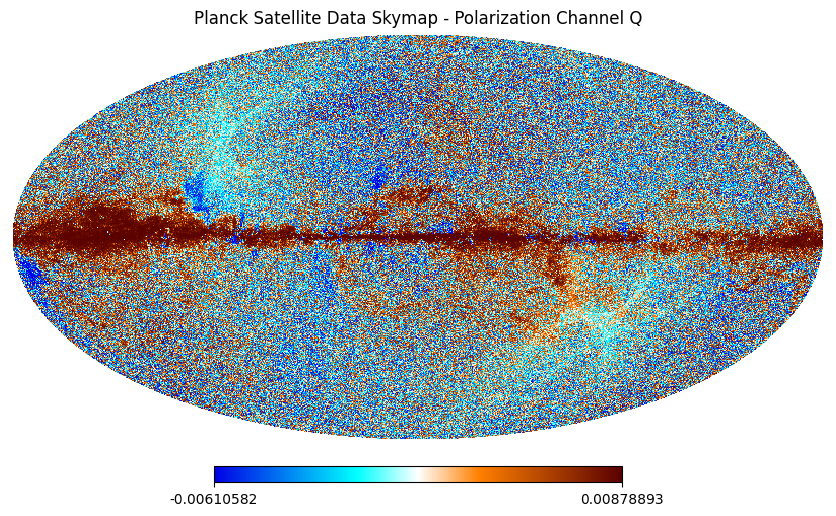

In [9]:
hp.mollview(temperature_channel_Q_ring, title="Planck Satellite Data Skymap - Polarization Channel Q", cmap=custom_cmap, norm='hist')
plt.show()

These maps are a fair bit noisier than the first one. <br>
To better visualize them, we can use the smoothing function provided by Healpy to clear them up:

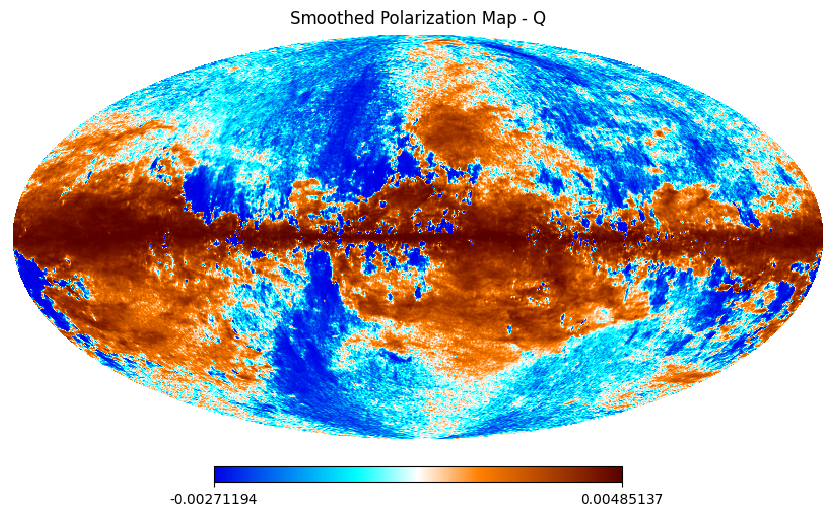

In [10]:
smoothed_Q = hp.smoothing(temperature_channel_Q_ring, fwhm=np.radians(0.5))

hp.mollview(smoothed_Q, title="Smoothed Polarization Map - Q", cmap=custom_cmap, norm='hist')
plt.show()

## Data Analysis

Now that we've taken a look at the skymaps visually, we can begin to analyze the data itself.
First, plotting a histogram of the pixel values:

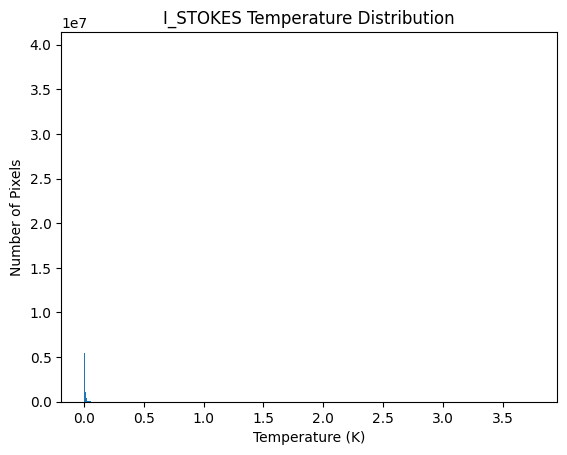

In [11]:
plt.hist(temperature_channel_I_ring, bins=1000)
plt.title('I_STOKES Temperature Distribution')
plt.xlabel('Temperature (K)')
plt.ylabel('Number of Pixels')
plt.show()

The graph is a bit difficult to read, let's put it on a log scale to better see the distribution: 

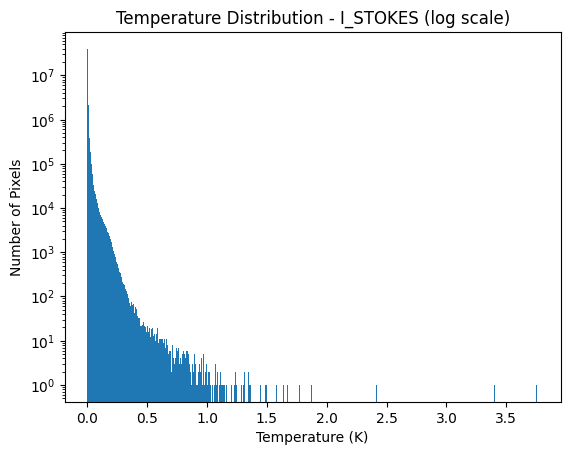

In [12]:
plt.hist(temperature_channel_I_ring, bins=1000)
plt.title('Temperature Distribution - I_STOKES (log scale)') 
plt.yscale('log')
plt.xlabel('Temperature (K)')
plt.ylabel('Number of Pixels')
plt.show()

We can use Healpy to perform spherical harmonics transforms, allowing us to compute the angular power spectrum of the map:

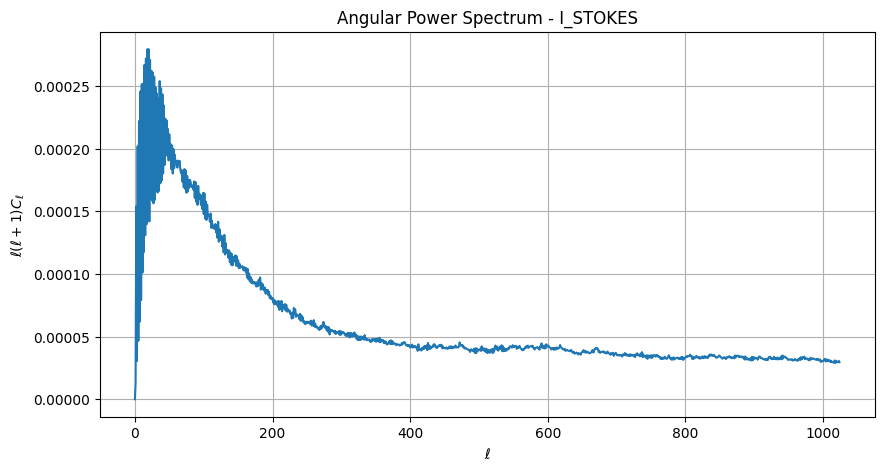

In [13]:
# Spherical Harmonics transforms
LMAX = 1024
cl = hp.anafast(temperature_channel_I_ring, lmax=LMAX)
ell = np.arange(len(cl))

# Plot the power spectrum
plt.figure(figsize=(10, 5))
plt.plot(ell, ell * (ell + 1) * cl)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}$')
plt.title('Angular Power Spectrum - I_STOKES')
plt.grid()
plt.show()